In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
from sklearn.svm import *
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import *
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import poisson, expon, uniform, randint
from sklearn.compose import ColumnTransformer
import random
import math

### Słowem wstępu:
Pracę domową rozpocząłem w piątek, 24 kwietnia, zatem dane samodzielnie przetransferowałem z pakietu R-owego oraz postanowiłem się zająć zadaniem regresji zmiennej 'm2.price'. Ponadto, punkt 1. treści zadania domowego jest częścią punktu 3., zatem od razu zająłem się poszukiwaniem optymalnych hiperparametrów.
#### Ponieważ oryginalnie w ramce danych 'apartments' znajduje się 1000 obserwacji, a w 'apartments_test' 9000 obserwacji, dla zwiększenia skuteczności algorytmu dokonamy zamiany zbiorów

In [3]:
apart_test = pd.read_csv('apartments.csv').drop('Unnamed: 0', axis = 1)
apart = pd.read_csv('apartments_test.csv').drop('Unnamed: 0', axis = 1)
apart.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,4644,1976,131,3,5,Srodmiescie
1,3082,1978,112,9,4,Mokotow
2,2498,1958,100,7,4,Bielany
3,2735,1951,112,3,5,Wola
4,2781,1978,102,4,4,Bemowo


In [4]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           9000 non-null   int64 
 1   construction.year  9000 non-null   int64 
 2   surface            9000 non-null   int64 
 3   floor              9000 non-null   int64 
 4   no.rooms           9000 non-null   int64 
 5   district           9000 non-null   object
dtypes: int64(5), object(1)
memory usage: 422.0+ KB


In [5]:
apart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [6]:
print("Zbiór treningowy:\n" + str(apart.district.value_counts(True)))
print("Zbiór testowy:\n" + str(apart_test.district.value_counts(True)))

Zbiór treningowy:
Praga          0.107889
Srodmiescie    0.102667
Ursus          0.102222
Ochota         0.101000
Bemowo         0.099556
Bielany        0.099333
Wola           0.099111
Mokotow        0.096444
Ursynow        0.096000
Zoliborz       0.095778
Name: district, dtype: float64
Zbiór testowy:
Mokotow        0.107
Wola           0.106
Ursus          0.105
Ursynow        0.103
Srodmiescie    0.100
Bemowo         0.098
Zoliborz       0.097
Ochota         0.096
Bielany        0.096
Praga          0.092
Name: district, dtype: float64


#### Zbiór danych składa się z mieszkań w dziesięciu dzielnicach Warszawy, podobna liczba obserwacji pochodzi z każdej z dzielnic. Co istotne, wszystkie dzielnice w zbiorze danych testowych znajdują się w danych do treningu

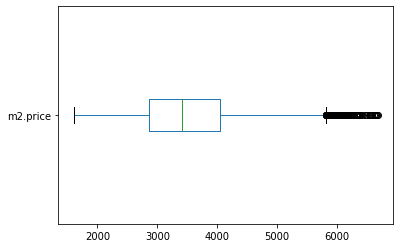

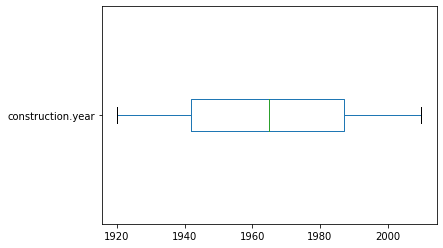

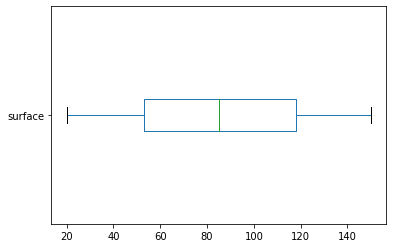

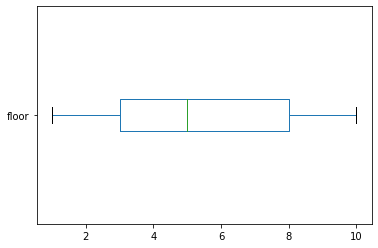

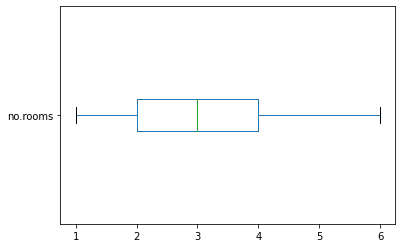

In [7]:
for col in apart.select_dtypes('int64').columns:
    apart[[col]].plot.box(vert = False)

#### Najczęściej mieszkania są w cenie 3000-4000 za metr kwadratowy. Cena za metr jest jedyną zmienną, w której występują wartości odstające. Mieszkania zazwyczaj są powierzchni 50-115 metrów kwadratowych, 2-4 pokojowe, na piętrach od parteru do 10.

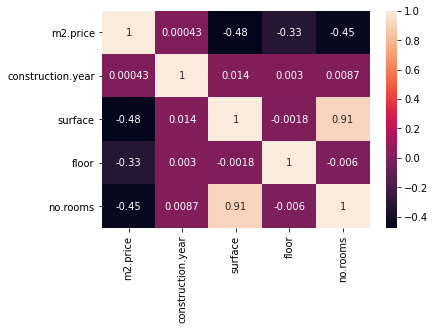

In [8]:
sns.heatmap(apart.corr(), annot=True)

#### Z macierzy korelacji nie ma wiele zaskakujących wniosków: najwyższa wartość współczynnika korelacji, dość oczekiwanie, wystąpiła między powierzchnią mieszkania a liczbą pomieszczeń. Co ciekawe, na im wyższym piętrze znajduje się mieszkanie, tym zwykle jest tańsze.

In [9]:
apart[['district', 'm2.price']].groupby('district').median()

,m2.price
district,
Bemowo,3030.0
Bielany,3057.5
Mokotow,3924.5
Ochota,3941.0
Praga,3054.0
Srodmiescie,5120.0
Ursus,3002.5
Ursynow,3003.0
Wola,3040.5


#### Im bliżej centrum, tym wyższa jest cena za metr kwadratowy mieszkania - najwyższa mediana cen w Śródmieściu, najniższa na Ursusie.
#### Oddzielmy dane od Targetu

In [10]:
train_target = apart['m2.price']
test_target = apart_test['m2.price']
apart = apart.drop('m2.price', axis = 1)
apart_test = apart_test.drop('m2.price', axis = 1)

#### W celu poprawnego stosowania kodowania zmiennej kateogrycznej w procesie poszukiwania optymalnych hiperparametrów, zastosujemy obiekt ColumnTransofrmer

In [12]:
column_transformer = ColumnTransformer([('encoder', TargetEncoder(cols = ['district']), ['district'])],
                                       remainder= 'passthrough')

ppl = Pipeline(steps = [('transformer', column_transformer), ('svr', SVR())])

param_distributions = {'svr__C': uniform(loc = 0.01, scale = 2),
                       'svr__gamma': ['scale', 'auto', random.random()/4],
                       'svr__degree': randint(low = 1, high = 3),
                       'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                       'svr__epsilon': uniform(0.02, scale = 0.3)}

rscv = RandomizedSearchCV(ppl, param_distributions=param_distributions,
                          scoring = 'neg_root_mean_squared_error',
                          cv = 4, random_state = 324, n_iter = 10,
                          verbose = 10**8)

apart_found = rscv.fit(apart, train_target)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.1249441435733914, svr__gamma=scale, svr__kernel=linear 
[CV]  svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.1249441435733914, svr__gamma=scale, svr__kernel=linear, score=-332.711, total=  39.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.7s remaining:    0.0s
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.1249441435733914, svr__gamma=scale, svr__kernel=linear 
[CV]  svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.1249441435733914, svr__gamma=scale, svr__kernel=linear, score=-330.751, total=  33.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.1249441435733914, svr__gamma=scale, svr__kernel=linear 
[CV]  svr__C=0.13063342713081472, svr__de

[CV]  svr__C=1.6740349500852558, svr__degree=2, svr__epsilon=0.3035585123146712, svr__gamma=0.006914520507181887, svr__kernel=linear, score=-1090.435, total=  38.7s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 11.7min remaining:    0.0s
[CV] svr__C=0.13473554207153948, svr__degree=1, svr__epsilon=0.2666538049658639, svr__gamma=0.006914520507181887, svr__kernel=rbf 
[CV]  svr__C=0.13473554207153948, svr__degree=1, svr__epsilon=0.2666538049658639, svr__gamma=0.006914520507181887, svr__kernel=rbf, score=-891.060, total=   4.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 11.7min remaining:    0.0s
[CV] svr__C=0.13473554207153948, svr__degree=1, svr__epsilon=0.2666538049658639, svr__gamma=0.006914520507181887, svr__kernel=rbf 
[CV]  svr__C=0.13473554207153948, svr__degree=1, svr__epsilon=0.2666538049658639, svr__gamma=0.006914520507181887, svr__kernel=rbf, score=-903.312, total=   4.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 11.8min remaining:    0.0s
[CV] svr_

### Uwagi co do strojenia hiperparametrów:
* SVR nie posiada parametru cost. Zamiennie zastosowałem parametr C - dodatni parametr regularyzacji
* Parametr gamma - sposób ustawienia współczynnika dla jądra w przypadku gdy jest ono jednym z 'rbf' - Gaussian radial basis function, 'poly' - Polynomial, 'sigmoid'. Wartość współczynnika w przypadku gdy gamma = 'scale' jest zależna od rozmiaru danych wejściowych i wynosi 1/(n_features() * X.var()). Gdy 'gamma' = 'auto', jego wartość to po prostu 1/n_features. Dla celów badawczych sprawdzimy również jak algorytm się spisze dla losowej, małej aczkolwiek małej dodatniej liczby z przedziału <0, 0.25).
* Parametr degree - określa stopień wielomianu dla jądra 'poly'. W przeciwnym razie - jest ignorowany. Co ciekawe, gdy degree było liczbą z zakresu 3-6, obliczenia trwały nieporównywalnie dłużej (żadne nie doszło do skutku w rozsądnym czasie)
* kernel - rodzaj jądra
* epsilon - o ile dobrze rozumiem, jest to określenie pewnego marginesu, na którym nie jest stosowana żadna kara za niepoprawną predykcję; możliwa pomyłka bez kary<br>
Jak możemy zauważyć, poszukiwanie optymalnych parametrów trwało długo - ponad 15 minut. Najwięcej czasu zajmuje dopasowanie modelu w przypadku jądra wielomianowego.

In [41]:
print("Czas działania poszczególnych podzbiorów parametrów:\n" + str(apart_found.cv_results_['mean_fit_time']) + '\n')
print('Czasy dla kernel = "poly": ' + 
      str(apart_found.cv_results_['mean_fit_time'][np.array([i['svr__kernel'] for i in apart_found.cv_results_['params']]) == 'poly']))

Czas działania poszczególnych podzbiorów parametrów:
[38.17239803 81.39708894  2.9170751   3.86667764  3.23599041 43.64670706
  3.41229856 67.30457932  2.05466413  3.45699054]

Czasy dla kernel = "poly": [81.39708894  2.9170751  67.30457932]


In [42]:
apart_found.cv_results_['params']

[{'svr__C': 0.13063342713081472,
  'svr__degree': 1,
  'svr__epsilon': 0.1249441435733914,
  'svr__gamma': 'scale',
  'svr__kernel': 'linear'},
 {'svr__C': 1.5026522303845276,
  'svr__degree': 1,
  'svr__epsilon': 0.3024735909065922,
  'svr__gamma': 'auto',
  'svr__kernel': 'poly'},
 {'svr__C': 1.1196209771872427,
  'svr__degree': 1,
  'svr__epsilon': 0.2251345287706828,
  'svr__gamma': 0.006914520507181887,
  'svr__kernel': 'poly'},
 {'svr__C': 1.869939196513775,
  'svr__degree': 2,
  'svr__epsilon': 0.11466162638446757,
  'svr__gamma': 'scale',
  'svr__kernel': 'sigmoid'},
 {'svr__C': 0.7690233392383132,
  'svr__degree': 1,
  'svr__epsilon': 0.15453592754094558,
  'svr__gamma': 'auto',
  'svr__kernel': 'rbf'},
 {'svr__C': 1.6740349500852558,
  'svr__degree': 2,
  'svr__epsilon': 0.3035585123146712,
  'svr__gamma': 0.006914520507181887,
  'svr__kernel': 'linear'},
 {'svr__C': 0.13473554207153948,
  'svr__degree': 1,
  'svr__epsilon': 0.2666538049658639,
  'svr__gamma': 0.0069145205071

#### Trudno powiedzieć co wpłynęło na tak krótki czas działania dla drugiego przypadku zawierającego 'poly'.

In [48]:
apart_found.best_params_

{'svr__C': 1.1196209771872427,
 'svr__degree': 1,
 'svr__epsilon': 0.2251345287706828,
 'svr__gamma': 0.006914520507181887,
 'svr__kernel': 'poly'}

#### Zbiór najlepszych hiperparametrów:
* C = 1.12
* gamma = 0.0069 - ciekawa obserwacja, lepsze niż sugerowane metody 'scale' i 'auto'
* kernel = 'poly'
* degree = 1 - również zaskakujące, że optymalny stopień wielomianu wyniósł tylko 1 (gwoli ścisłości, sprawdzona była też wartość 2)
* epsilon = 0.225

In [49]:
math.sqrt(mean_squared_error(test_target, apart_found.best_estimator_.predict(apart_test)))

318.95826079822604

## Drugi zbiór danych - zawodnicy w grze FIFA 20

In [15]:
fifa_read = pd.read_csv('players_20.csv')

In [16]:
fifa_numeric = fifa_read.select_dtypes(['float64', 'int64'])
fifa_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sofifa_id                   18278 non-null  int64  
 1   age                         18278 non-null  int64  
 2   height_cm                   18278 non-null  int64  
 3   weight_kg                   18278 non-null  int64  
 4   overall                     18278 non-null  int64  
 5   potential                   18278 non-null  int64  
 6   value_eur                   18278 non-null  int64  
 7   wage_eur                    18278 non-null  int64  
 8   international_reputation    18278 non-null  int64  
 9   weak_foot                   18278 non-null  int64  
 10  skill_moves                 18278 non-null  int64  
 11  release_clause_eur          16980 non-null  float64
 12  team_jersey_number          18038 non-null  float64
 13  contract_valid_until        180

#### Starałem się dokonać selekcji moim zdaniem najważniejszych zmiennych

In [17]:
fifa_selected = fifa_numeric[['age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur',
                              'international_reputation','weak_foot', 'skill_moves', 'pace', 'shooting', 'passing',
                              'dribbling', 'defending', 'physic']]

In [18]:
fifa_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       18278 non-null  int64  
 1   height_cm                 18278 non-null  int64  
 2   weight_kg                 18278 non-null  int64  
 3   overall                   18278 non-null  int64  
 4   potential                 18278 non-null  int64  
 5   value_eur                 18278 non-null  int64  
 6   international_reputation  18278 non-null  int64  
 7   weak_foot                 18278 non-null  int64  
 8   skill_moves               18278 non-null  int64  
 9   pace                      16242 non-null  float64
 10  shooting                  16242 non-null  float64
 11  passing                   16242 non-null  float64
 12  dribbling                 16242 non-null  float64
 13  defending                 16242 non-null  float64
 14  physic

#### Wykorzystajmy jedynie obserwacje bez braków danych - pozostali to najprawdopodbniej bramkarze, dla których niektóre atrybuty nie zostały określone

In [19]:
fifa = fifa_selected.dropna().reset_index()

In [20]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16242 non-null  int64  
 1   age                       16242 non-null  int64  
 2   height_cm                 16242 non-null  int64  
 3   weight_kg                 16242 non-null  int64  
 4   overall                   16242 non-null  int64  
 5   potential                 16242 non-null  int64  
 6   value_eur                 16242 non-null  int64  
 7   international_reputation  16242 non-null  int64  
 8   weak_foot                 16242 non-null  int64  
 9   skill_moves               16242 non-null  int64  
 10  pace                      16242 non-null  float64
 11  shooting                  16242 non-null  float64
 12  passing                   16242 non-null  float64
 13  dribbling                 16242 non-null  float64
 14  defend

#### Udało nam sie przygotować całkiem pokaźny zbiór danych o wymiarach 16242 x 15.

In [21]:
fifa.corr()

,index,age,height_cm,weight_kg,overall,potential,value_eur,international_reputation,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic
index,1.000000,-0.437896,-0.063343,-0.175966,-0.973598,-0.638629,-0.544546,-0.393322,-0.218572,-0.495640,-0.154866,-0.486231,-0.667273,-0.585396,-0.327378,-0.504749
age,-0.437896,1.000000,0.065503,0.222893,0.465977,-0.275971,0.087288,0.264483,0.109420,0.130075,-0.201211,0.238990,0.330507,0.161913,0.259990,0.435292
height_cm,-0.063343,0.065503,1.000000,0.752597,0.065984,0.021387,0.025051,0.043452,-0.097984,-0.280113,-0.432158,-0.203716,-0.290623,-0.413370,0.216422,0.490354
weight_kg,-0.175966,0.222893,0.752597,1.000000,0.182136,0.009379,0.066650,0.097335,-0.055569,-0.201295,-0.387138,-0.095442,-0.182688,-0.300792,0.218564,0.581971
overall,-0.973598,0.465977,0.065984,0.182136,1.000000,0.636026,0.645949,0.478061,0.227624,0.493554,0.158866,0.497881,0.683954,0.601190,0.334792,0.517214
potential,-0.638629,-0.275971,0.021387,0.009379,0.636026,1.000000,0.581976,0.337049,0.150349,0.380834,0.229060,0.304000,0.424816,0.451097,0.151608,0.148449
value_eur,-0.544546,0.087288,0.025051,0.066650,0.645949,0.581976,1.000000,0.621826,0.170129,0.370318,0.171373,0.343938,0.448258,0.427721,0.157928,0.236395
international_reputation,-0.393322,0.264483,0.043452,0.097335,0.478061,0.337049,0.621826,1.000000,0.134880,0.260275,0.004324,0.274709,0.355577,0.296900,0.138748,0.176956
weak_foot,-0.218572,0.109420,-0.097984,-0.055569,0.227624,0.150349,0.170129,0.134880,1.000000,0.266627,0.148527,0.319034,0.281381,0.309823,-0.105863,0.000952
skill_moves,-0.495640,0.130075,-0.280113,-0.201295,0.493554,0.380834,0.370318,0.260275,0.266627,1.000000,0.420886,0.625012,0.611950,0.714841,-0.209321,-0.066725


### Naszą zmienną objaśnianą będzie wartość zawodników - kolumna 'value_eur'. Najbardziej skorelowana z nią jest kolumna overall - łączny wynik umiejętności gracz. Wsp. korelacji: 0.64

#### Podział danych na treningowe i testowe:

In [22]:
data_train, data_test, target_train, target_test = train_test_split(fifa.drop('value_eur', axis = 1), fifa.value_eur)

In [ ]:
param_distributions = {'C': uniform(loc = 0.01, scale = 2),
                       'gamma': ['scale', 'auto', random.random()/4],
                       'degree': [1], # Tylko 1, gdy 'poly' natrafił na 2, czas działania na tak dużym zbiorze rósł dramatycznie
                       'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                       'epsilon': uniform(0.02, scale = 0.3)}



fifa_rscv = RandomizedSearchCV(SVR(), param_distributions=param_distributions,
                          scoring = 'neg_root_mean_squared_error',
                          cv = 4, random_state = 794, n_iter = 10,
                          verbose = 10**8)

fifa_found = fifa_rscv.fit(data_train, target_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1.6860268988646951, degree=1, epsilon=0.31706150737197836, gamma=0.19555736376084007, kernel=linear 


In [51]:
fifa_found.best_params_

{'C': 2.000042526855012,
 'degree': 1,
 'epsilon': 0.1905392402409395,
 'gamma': 'auto',
 'kernel': 'linear'}

#### Tym razem proces poszukiwania optymalnych hiperparametrów przyniósł zgoła odmienne wyniki. Najlepszym jądrem okazało się liniowe, optymalna automatyczna wartość parametru gamma, a najkorzystniejszy parametr regularyzacji C wyniósł 2.

In [53]:
math.sqrt(mean_squared_error(target_test, fifa_found.best_estimator_.predict(data_test)))

4863447.91997123